# MMI splitter and MMI reflector
Control which one with the `reflector` variable. To see transmission of the splitter, you have to change the position of the monitor port.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import shutil
from IPython import display

import meep as mp

import sys
sys.path.append('../../lib')
from meep_nb import *

from lightlab.util import io
from lightlab.util.data import Spectrum, FunctionBundle, MeasuredFunction

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
io.dataHome /= 'reflectors'

In [9]:
# Define the system
# parameters for 1220nm
sm_width = .35
default_geometry = dict(
                        sm_width = .35,  # um
                        MMI_width = 2.05,
                        reflector = False,
#                         MMI_length = 4.8, #if reflector else 5.7,
                        MMI_length = 5.7,
                        tip_angle = 90,
                        out_pitch = 1.12)


cell = mp.Vector3(24, 8, 0)
background = mp.Block(mp.Vector3(cell.x, cell.y, 1e20),
                     center=mp.Vector3(0, 0),
                     material=mp.Medium(epsilon=3.9))

def give_geometry(**kwargs):
    geom_dict = default_geometry.copy()
    geom_dict.update(kwargs)
    geo = objview(**geom_dict)
    
    geometry = [background,
                mp.Block(mp.Vector3(cell.x / 2, geo.sm_width, 1e20),
                         center=mp.Vector3(-cell.x / 4, 0),
                         material=mp.Medium(epsilon=12)),
                mp.Block(mp.Vector3(geo.MMI_length, geo.MMI_width, 1e20),
                         center=mp.Vector3(geo.MMI_length / 2, 0),
                         material=mp.Medium(epsilon=12)),   
               ]

    if geo.reflector:
        extended = geo.MMI_width / 2 / (np.tan(np.pi / 180 * geo.tip_angle / 2))
        geometry.extend([
                        mp.Prism([mp.Vector3(geo.MMI_length, geo.MMI_width / 2),
                                  mp.Vector3(geo.MMI_length, -geo.MMI_width / 2),
                                  mp.Vector3(geo.MMI_length + extended, 0),
                                 ],
                                 height=0, material=mp.Medium(epsilon=12)),
                        # This is the entry side
#                         mp.Prism([mp.Vector3(0, geo.MMI_width / 2),
#                                   mp.Vector3(0, -geo.MMI_width / 2),
#                                   mp.Vector3(-geo.MMI_width/4, 0),
#                                  ],
#                                  height=0, material=mp.Medium(epsilon=12)),
                        ])

    else:
        geometry.extend([
                        mp.Block(mp.Vector3(cell.x / 2, geo.sm_width, 1e20),
                                 center=mp.Vector3(cell.x / 4, geo.out_pitch / 2),
                                 material=mp.Medium(epsilon=12)),
                        mp.Block(mp.Vector3(cell.x / 2, geo.sm_width, 1e20),
                                 center=mp.Vector3(cell.x / 4, -geo.out_pitch / 2),
                                 material=mp.Medium(epsilon=12)),
                        ])
    return geometry

geometry = give_geometry()
    
dpml = 1.
pml_layers = [mp.PML(dpml)]

# this should be replaced by an eigenmode
fcen = 1 / 1.22
df = fcen / 3
nfreq = 101
sources = [mp.Source(mp.GaussianSource(fcen, fwidth=df), 
                     component=mp.Ey,
                     center=mp.Vector3(-cell.x / 2 + dpml, 0), 
                     size=mp.Vector3(0, sm_width))]
# sources = [mp.Source(mp.ContinuousSource(frequency=fcen, width=2),
#                      component=mp.Ez,
#                      center=mp.Vector3(-cell.x / 2 + dpml, 0),
# #                      center=mp.Vector3(cell.x / 2 - dpml, out_pitch / 2),  # not working
#                      size=mp.Vector3(0, sm_width))]

resolution = 20

-----------
Initializing structure...
run 0 finished at t = 0.0 (0 timesteps)


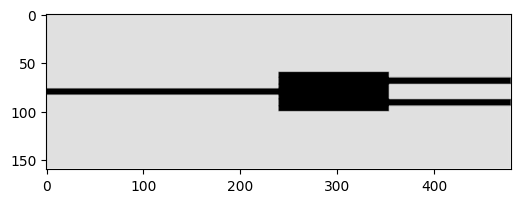

In [10]:
# Do the simulation, and verify the geometry
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution,
                    symmetries=[mp.Mirror(mp.Y, phase=-1)],
                    progress_interval=1e6)

eps_data = show_geometry(sim)

In [11]:
def livefield(sim):
    liveplot(sim, mp.Ey)
    

run 1 finished at t = 160.0 (6400 timesteps)


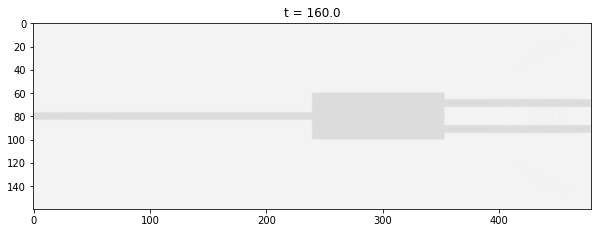

In [12]:
def plot_sim(until=200):
    sim.reset_meep()
    shutil.rmtree('outputs', ignore_errors=True)
    sim.use_output_directory('outputs')
    sim.run(
            mp.at_beginning(livefield),
            mp.at_every(5, livefield),
            mp.at_every(1, mp.output_png(mp.Ey, "-Zc dkbluered")),
#             mp.to_appended("ez", mp.at_every(0.6, mp.output_efield_z)),
            until=until)
    # now make the gif
    subprocess.check_call(['convert', 'outputs/ey-*.png', 'ey.gif'])
    subprocess.check_call(['open', '-a', 'Safari', 'ey.gif'])

plt.figure(figsize=(10,6))
plot_sim(160)

field decay(t = 200.10000000000002): 2.6054372263916056e-15 / 0.028543400740641798 = 9.127984608651865e-14
run 0 finished at t = 200.10000000000002 (8004 timesteps)


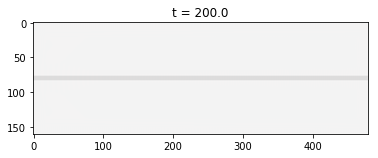

In [13]:
# Ok first do the straight waveguide
def do_baseline():
    
    straight_geometry = [background,
                        mp.Block(mp.Vector3(cell.x, sm_width, 1e20),
                                 center=mp.Vector3(0, 0),
                                 material=mp.Medium(epsilon=12))]
    sim = mp.Simulation(cell_size=cell,
                        boundary_layers=pml_layers,
                        geometry=straight_geometry,
                        sources=sources,
                        resolution=resolution,
                        symmetries=[mp.Mirror(mp.Y, phase=-1)],
                        progress_interval=1e6)
    sim.reset_meep()

    # Now put in some flux monitors. Make sure the pulse source was selected
    # reflected flux
    refl_fr = mp.FluxRegion(center=mp.Vector3(-cell.x / 2 + dpml + .5,0,0), size=mp.Vector3(0,2*sm_width,0))                            
    refl = sim.add_flux(fcen, df, nfreq, refl_fr)

    # transmitted flux
    tran_fr = mp.FluxRegion(center=mp.Vector3(cell.x / 2 - dpml, 0,0), size=mp.Vector3(0,2*sm_width,0))
    tran = sim.add_flux(fcen, df, nfreq, tran_fr)

    # Do it
    monitor_pt = mp.Vector3(cell.x/2-dpml-0.5,0)
    sim.run(mp.at_beginning(livefield),
            mp.at_every(5, livefield),    
            until_after_sources=mp.stop_when_fields_decayed(50,mp.Ey, monitor_pt,1e-3))

    # for normalization run, save flux fields data for reflection plane
    straight_refl_data = sim.get_flux_data(refl)
    # transmission flux. Note this is entirely different purpose than the above line
    # This one is to normalize power. the other was to negate forward-propagating wave
    straight_tran_flux = mp.get_fluxes(tran)
    return straight_refl_data, straight_tran_flux

straight_refl_data, straight_tran_flux = do_baseline()  # comment this when you dont need to do it again

field decay(t = 150.07500000000002): 2.6772333872672395e-05 / 0.027573752051943134 = 0.0009709354687109308
run 0 finished at t = 150.07500000000002 (6003 timesteps)


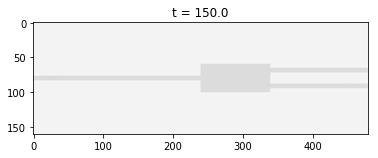

In [14]:
def do_trial(straight_refl_data, with_geometry=geometry, do_live=True):
    sim = mp.Simulation(cell_size=cell,
                        boundary_layers=pml_layers,
                        geometry=with_geometry,
                        sources=sources,
                        resolution=resolution,
                        symmetries=[mp.Mirror(mp.Y, phase=-1)],
#                         progress_interval=1e6,
                       )
    sim.reset_meep()
    # reflected flux
    refl_fr = mp.FluxRegion(center=mp.Vector3(-cell.x / 2 + dpml + .5,0,0), size=mp.Vector3(0,2*sm_width,0))                            
    refl = sim.add_flux(fcen, df, nfreq, refl_fr)
    # for normal run, load negated fields to subtract incident from refl. fields
    sim.load_minus_flux_data(refl, straight_refl_data)

    monitor_pt = mp.Vector3(0,0)
    run_args = (mp.at_beginning(livefield), mp.at_every(5, livefield),) if do_live else tuple()
    sim.run(*run_args,
            until_after_sources=mp.stop_when_fields_decayed(50,mp.Ey, monitor_pt,1e-3))
    return refl

refl = do_trial(straight_refl_data, with_geometry=give_geometry(MMI_length=5))
bend_refl_flux = np.array(mp.get_fluxes(refl))
flux_freqs = np.array(mp.get_flux_freqs(refl))

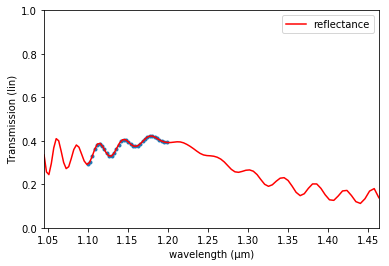

In [19]:
wl = 1 / flux_freqs
Rs = -bend_refl_flux/np.array(straight_tran_flux)
spct = Spectrum(wl[::-1], Rs[::-1], inDbm=False)
spct.crop([1.1,1.2]).simplePlot('.')
plt.plot(wl,Rs,'r-',label='reflectance')
# plt.plot(wl,1-Rs,'go-',label='loss')
# plt.axis([1.0, 1.44, 0, 1])
plt.ylim([0,1])
plt.xlabel("wavelength (μm)")
plt.legend(loc="upper right")


In [20]:
# parameter sweep
isResimulating = True
isSaving = True
filename = 'shovel-length.pkl'

L_vals = np.linspace(4, 8, 31)
theta_vals = np.linspace(80, 100, 10)
W_vals = np.linspace(2, 2.1, 3)

if isResimulating:
    param_vals = L_vals
    spectra = FunctionBundle()
    for p in param_vals:
        refl = do_trial(straight_refl_data, 
                        with_geometry=give_geometry(MMI_length=p), 
                        do_live=False)
        bend_refl_flux = np.array(mp.get_fluxes(refl))
        Rs = -bend_refl_flux/straight_tran_flux
        spct1 = Spectrum(wl[::-1], Rs[::-1], inDbm=False)
        spectra.addDim(spct1.db())
    if isSaving:
        io.savePickleGzip(dataTuple=(param_vals, spectra), filename=filename)
else:
    param_vals, spectra = io.loadPickleGzip(filename=filename)
   

-----------
Initializing structure...
field decay(t = 50.025000000000006): 9.225127497723313e-08 / 9.225127497723313e-08 = 1.0
field decay(t = 100.05000000000001): 0.027572691412857793 / 0.027572691412857793 = 1.0
field decay(t = 150.07500000000002): 0.006586040815005824 / 0.027572691412857793 = 0.23886100621771722
field decay(t = 200.10000000000002): 1.9200745528560433e-06 / 0.027572691412857793 = 6.963682014591682e-05
run 0 finished at t = 200.10000000000002 (8004 timesteps)
-----------
Initializing structure...
field decay(t = 50.025000000000006): 9.225157049621889e-08 / 9.225157049621889e-08 = 1.0
field decay(t = 100.05000000000001): 0.02757213370104693 / 0.02757213370104693 = 1.0
field decay(t = 150.07500000000002): 0.007732238104288861 / 0.02757213370104693 = 0.2804366969972753
field decay(t = 200.10000000000002): 1.3367680714139655e-06 / 0.02757213370104693 = 4.848257613676114e-05
run 0 finished at t = 200.10000000000002 (8004 timesteps)
-----------
Initializing structure...
fie

field decay(t = 100.05000000000001): 0.027572451062521704 / 0.027572451062521704 = 1.0
field decay(t = 150.07500000000002): 0.004647856088067229 / 0.027572451062521704 = 0.16856883987310445
field decay(t = 200.10000000000002): 2.578156354343774e-05 / 0.027572451062521704 = 0.0009350479391540835
run 0 finished at t = 200.10000000000002 (8004 timesteps)
-----------
Initializing structure...
field decay(t = 50.025000000000006): 9.225169972449538e-08 / 9.225169972449538e-08 = 1.0
field decay(t = 100.05000000000001): 0.027572452400983886 / 0.027572452400983886 = 1.0
field decay(t = 150.07500000000002): 0.004785600302955693 / 0.027572452400983886 = 0.1735645503475391
field decay(t = 200.10000000000002): 2.2913207590439043e-05 / 0.027572452400983886 = 0.000831018121174503
run 0 finished at t = 200.10000000000002 (8004 timesteps)
-----------
Initializing structure...
field decay(t = 50.025000000000006): 9.225169967134277e-08 / 9.225169967134277e-08 = 1.0
field decay(t = 100.05000000000001): 0.

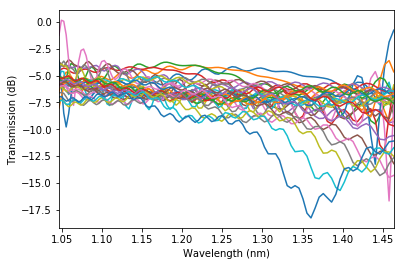

In [21]:
spectra.simplePlot()
# sp = spectra[0]
# sp.lin().simplePlot()
# spct.db().simplePlot()